# Executive Summary
This project compared the performance of GPT-4.1 and GPT-4o-mini on different email editing tasks, including elaboration, shortening, and tone adjustment. Each model's output was scored by two independent LLM reviewers, evaluating faithfulness (adherence to the original text) and completeness (whether the content was fully extended or supplemented). In addition to real email data, we also generated some emails containing edge cases using scripts to test the models' stability under different lengths and task objectives. The experimental results showed that GPT-4.1 had a higher and more stable average score in completeness (4.87), while GPT-4o-mini had a slight advantage in faithfulness. Considering all types of tasks, especially the requirement for completeness when content expansion is needed, and given the need for a conservative decision when only one model can be chosen, we ultimately selected GPT-4.1 as the primary model.

# Model Overview:
We are using two different models, both provided by OpenAI: ChatGPT 4.1 and ChatGPT 4o-mini. 

# Method and Performance Metrics:

For each model-generated output, we use two independent LLM reviewers to assign scores, evaluating both faithfulness and completeness. Faithfulness measures whether the output content is strictly supported by the original input, focusing on whether the model introduces facts not mentioned in the original text, causes semantic drift, or alters the original intent. Completeness, on the other hand, measures the model's ability to reasonably continue and expand upon the content given the task, evaluating whether it completes and covers the key information points required by the task, and whether the output forms a complete and coherent text at both the logical and informational levels.

## Benchmarks:

In the prompt for the LLM judge, I set five scores from 1 to 5, instructing the LLM to strictly follow this rule when scoring the output:

### For completeness:
      5 - Fully complete:
          The edited text preserves all critical and non-critical information
          required to complete the intended task, including any essential
          links, references, deadlines, or instructions. No meaningful or
          operational gaps are present.

      4 - Mostly complete:
          The edited text preserves all critical information required to
          complete the task, but omits or underdevelops some secondary,
          contextual, or optional details.

      3 - Moderately complete:
          The edited text addresses the main intent but omits multiple
          important details, constraints, or implied requirements,
          reducing clarity or executability.

      2 - Largely incomplete:
          The edited text covers only part of the main intent and misses
          many key requirements or pieces of critical supporting information.

      1 - Severely incomplete:
          The edited text fails to address the core intent of the original
          message or omits most critical information, making the task
          difficult or impossible to complete.

### For faithfulness:
      5 - Fully faithful:
          All content in the edited text is fully supported by
          the original text or clearly and directly implied.
          No hallucinations or misleading additions are present.

      4 - Mostly faithful:
          The edited text is largely supported by the original text,
          but includes very minor assumptions or elaborations
          that slightly go beyond what is stated.

      3 - Partially faithful:
          The edited text includes several unsupported assumptions,
          extrapolations, or reinterpretations that are not clearly
          grounded in the original text.

      2 - Largely unfaithful:
          The edited text introduces many details or claims
          that are not supported by the original text
          and could misrepresent its intent.

      1 - Severely unfaithful:
          Most or all of the edited text is not grounded
          in the original text and contains significant hallucination.

### Data Stnthesis:
I also wrote a separate Python script to generate test email data containing edge cases, such as embedded image links and special characters in email addresses. This data was also generated by ChatGPT 4.1; in preliminary testing, we found no significant difference in performance between gpt-4.1 and gpt-4o-mini on email generation tasks, so we chose to use gpt-4.1 to generate all input data. The script supports flexible configuration of the generated email length and target task type, such as different editing scenarios like elaborate, shorten, or tone, ensuring controllability and diversity in the structural complexity and task objectives of the evaluation data. For each task, I used the script to generate 25 additional edge cases for model comparison testing.

In [5]:
import json
import pandas as pd
import matplotlib.pyplot as plt

LOG_PATH = "/Users/jerry.yang/Desktop/ai_bootcamp/ai_bootcamp_starter/logs/batch_experiments.jsonl"

records = []
with open(LOG_PATH, "r", encoding="utf-8") as f:
    for line in f:
        if not line.strip():
            continue
        r = json.loads(line)
        records.append(r)

df = pd.DataFrame(records)

In [6]:
rows = []

for _, r in df.iterrows():
    for metric in ["faithfulness", "completeness"]:
        rows.append({
            "model": r["model"],
            "operation": r["operation"],
            "metric": metric,
            "score": r[f"{metric}_rating"]
        })

score_df = pd.DataFrame(rows)
print(score_df.head())

         model operation        metric  score
0  gpt-4o-mini   shorten  faithfulness      5
1  gpt-4o-mini   shorten  completeness      5
2  gpt-4o-mini   shorten  faithfulness      5
3  gpt-4o-mini   shorten  completeness      4
4  gpt-4o-mini   shorten  faithfulness      5


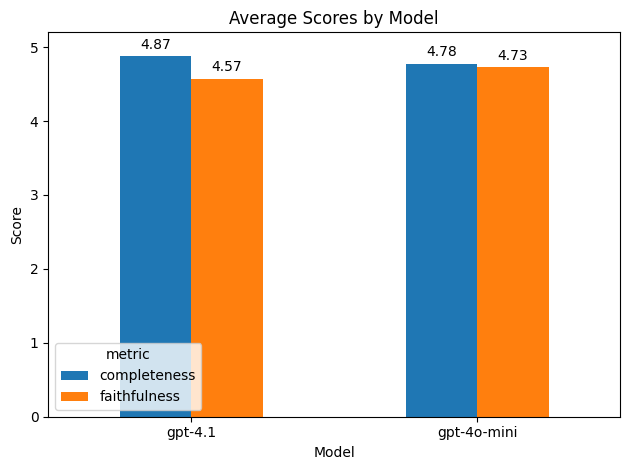

In [7]:
ax = avg_by_model.plot(kind="bar")

plt.title("Average Scores by Model")
plt.ylabel("Score")
plt.xlabel("Model")
plt.xticks(rotation=0)
plt.ylim(0, 5.2)
plt.tight_layout()

for container in ax.containers:
    ax.bar_label(
        container,
        fmt="%.2f",
        label_type="edge",
        padding=3
    )

plt.show()

GPT-4.1 achieved a higher average score in completeness (4.87), while GPT-4o-mini had a slight advantage in faithfulness (4.73). This suggests that GPT-4.1 is better at providing comprehensive content continuation and information completion in editing tasks, while GPT-4o-mini tends to maintain stricter fidelity to the original text's semantics. Of course, the influence of the model's preset temperature cannot be ruled out.

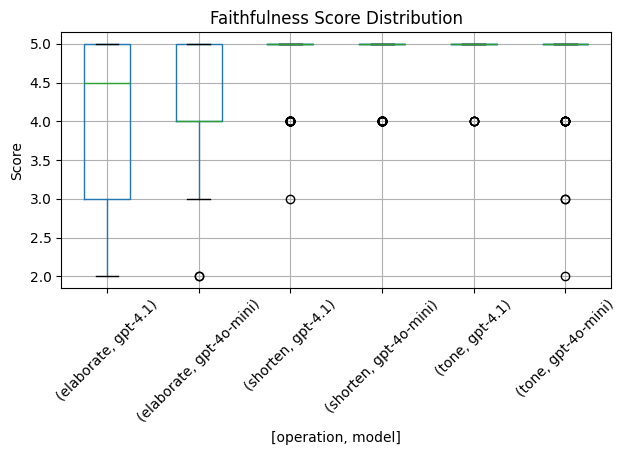

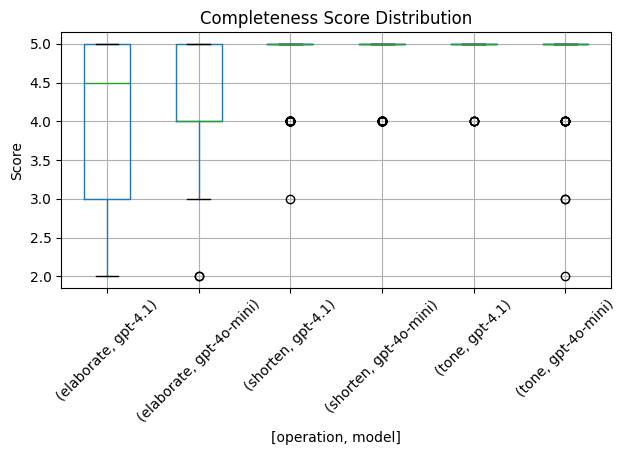

In [8]:
for metric in ["faithfulness", "completeness"]:
    score_df.boxplot(
        column="score",
        by=["operation", "model"]
    )
    plt.title(f"{metric.capitalize()} Score Distribution")
    plt.suptitle("")
    plt.ylabel("Score")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()


In the faithfulness distribution analysis, the main differences between the models were observed in the elaborate task. GPT-4.1 showed a more dispersed score distribution in this task, with scores as low as 2, indicating that when more content expansion is required, the model is more likely to introduce information not explicitly supported by the original text. In contrast, GPT-4o-mini's scores were more concentrated in the 4–5 range, demonstrating more stable and conservative rewriting behavior. In the other two actions, the models' performance was mostly concentrated at 5, meaning both models performed well in these two actions, with no significant differences between them.

In the completeness distribution results, the advantages of GPT-4.1 are quite evident, especially in elaborate tasks. GPT-4.1's scores are mostly concentrated at 5 points, and the overall distribution is relatively stable (with a higher median). In contrast, while GPT-4o-mini also performs well overall, it is more prone to scoring 3–4 points in the same tasks, indicating that it occasionally misses some minor but still important points when the content is complex or contains a large amount of information. Overall, these results suggest that GPT-4.1 is more suitable for tasks aimed at content completion and comprehensive expression, while GPT-4o-mini is more suitable for relatively conservative, lower-risk rewriting tasks.

Ideally, we should use different models for different tasks, but if we can only choose one, based on our experimental data, I would choose ChatGPT 4.1. This is because, for email-related tasks, completeness, which represents the comprehensiveness of the information, is considered a more important metric.

# Deployment:
https://emailappai-gzzxymunrumv5xapiwahkr.streamlit.app/